# Стоимость поддержанного автомобиля

Предсказание стоимости автомобиля на вторичном рынке.

## Описание задачи

Многие знают про маркетплейсы где продаются б/у вещи, на которых есть возможность недорого купить качественную и полезную вещь. Но всегда волнует вопрос - кто и как устанавливает цену, и какие его характеристики больше всего влияют на итоговую стоимость продажи?! Вопрос становиться особо актуальным, если речь идет про дорогие товары, например про автомобили!

Целью проекта будет разработанная модель предсказания стоимости автомобиля на вторичном рынке.

### Описание данных

Наша задача - разработать модель для предсказания стоимости продажи автомобиля на вторичном рынке.

train.csv - информация о продажах автомобилей с аукционов, которые будут использоваться в качестве обучающих данных.

test.csv - информация о продажах автомобилей с аукционов, которые будут использоваться в качестве тестовых данных.

sample_submission.csv - файл предсказаний в правильном формате.

vin - идентификатор каждого автомобиля в тестовом наборе.

sellingprice - Целевой признак.

'year' - год производства

'make' - производитель

'model' - модель

'trim' - модификация

'body' - тип кузова

'transmission' - тип КПП

'vin' - идентификатор (вин)

'state' - штат регистрации

'condition' - состояние по шкале (1-5)

'odometer' - пробег

'color' - цвет кузова

'interior' - цвет интерьера

'seller' - продавец

'sellingprice' - стоимость продажи

'saledate' - дата продажи

#### Примечаниe:

Для оценки качества моделей применяем метрику MAPE.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings

In [2]:
pd.options.mode.chained_assignment = None
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
!pip install vininfo

In [106]:
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import make_scorer

from vininfo import Vin

In [5]:
!pip install -q lightgbm==3.3.5
import lightgbm as lgb

In [6]:
!pip install -q python-Levenshtein
from Levenshtein import distance as lev

## Загрузка и анализ данных

In [7]:
df = pd.read_csv('C:/Users/Family/Downloads/used-cars-price-prediction-22ds/train.csv')
test = pd.read_csv('C:/Users/Family/Downloads/used-cars-price-prediction-22ds/test.csv')

In [8]:
def describe_df(df):
    display(df.head())
    print('-----------------------------------------------------------------------------------------------')
    display(df.info())
    print('-----------------------------------------------------------------------------------------------')
    display(df.describe())
    print('-----------------------------------------------------------------------------------------------')
    display(f'Количество дубликатов: {df.duplicated().sum()}')

In [9]:
describe_df(df)

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,saledate
0,2011,Ford,Edge,SEL,suv,automatic,2fmdk3jc4bba41556,md,4.2,111041.0,black,black,santander consumer,12500,Tue Jun 02 2015 02:30:00 GMT-0700 (PDT)
1,2014,Ford,Fusion,SE,Sedan,automatic,3fa6p0h75er208976,mo,3.5,31034.0,black,black,ars/avis budget group,14500,Wed Feb 25 2015 02:00:00 GMT-0800 (PST)
2,2012,Nissan,Sentra,2.0 SL,sedan,automatic,3n1ab6ap4cl698412,nj,2.2,35619.0,black,black,nissan-infiniti lt,9100,Wed Jun 10 2015 02:30:00 GMT-0700 (PDT)
3,2003,HUMMER,H2,Base,suv,automatic,5grgn23u93h101360,tx,2.8,131301.0,gold,beige,wichita falls ford lin inc,13300,Wed Jun 17 2015 03:00:00 GMT-0700 (PDT)
4,2007,Ford,Fusion,SEL,Sedan,automatic,3fahp08z17r268380,md,2.0,127709.0,black,black,purple heart,1300,Tue Feb 03 2015 04:00:00 GMT-0800 (PST)


-----------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440236 entries, 0 to 440235
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          440236 non-null  int64  
 1   make          432193 non-null  object 
 2   model         432113 non-null  object 
 3   trim          431899 non-null  object 
 4   body          429843 non-null  object 
 5   transmission  388775 non-null  object 
 6   vin           440236 non-null  object 
 7   state         440236 non-null  object 
 8   condition     430831 non-null  float64
 9   odometer      440167 non-null  float64
 10  color         439650 non-null  object 
 11  interior      439650 non-null  object 
 12  seller        440236 non-null  object 
 13  sellingprice  440236 non-null  int64  
 14  saledate      440236 non-null  object 
dtypes: float64(2), int64(2), object(11)
memo

None

-----------------------------------------------------------------------------------------------


,year,condition,odometer,sellingprice
count,440236.000000,430831.000000,440167.000000,440236.000000
mean,2010.040101,3.425077,68344.421604,13592.209588
std,3.977945,0.949973,53542.203908,9751.479098
min,1982.000000,1.000000,1.000000,1.000000
25%,2007.000000,2.700000,28258.000000,6900.000000
50%,2012.000000,3.600000,52098.000000,12100.000000
75%,2013.000000,4.200000,99272.000000,18200.000000
max,2015.000000,5.000000,999999.000000,230000.000000


-----------------------------------------------------------------------------------------------


'Количество дубликатов: 0'

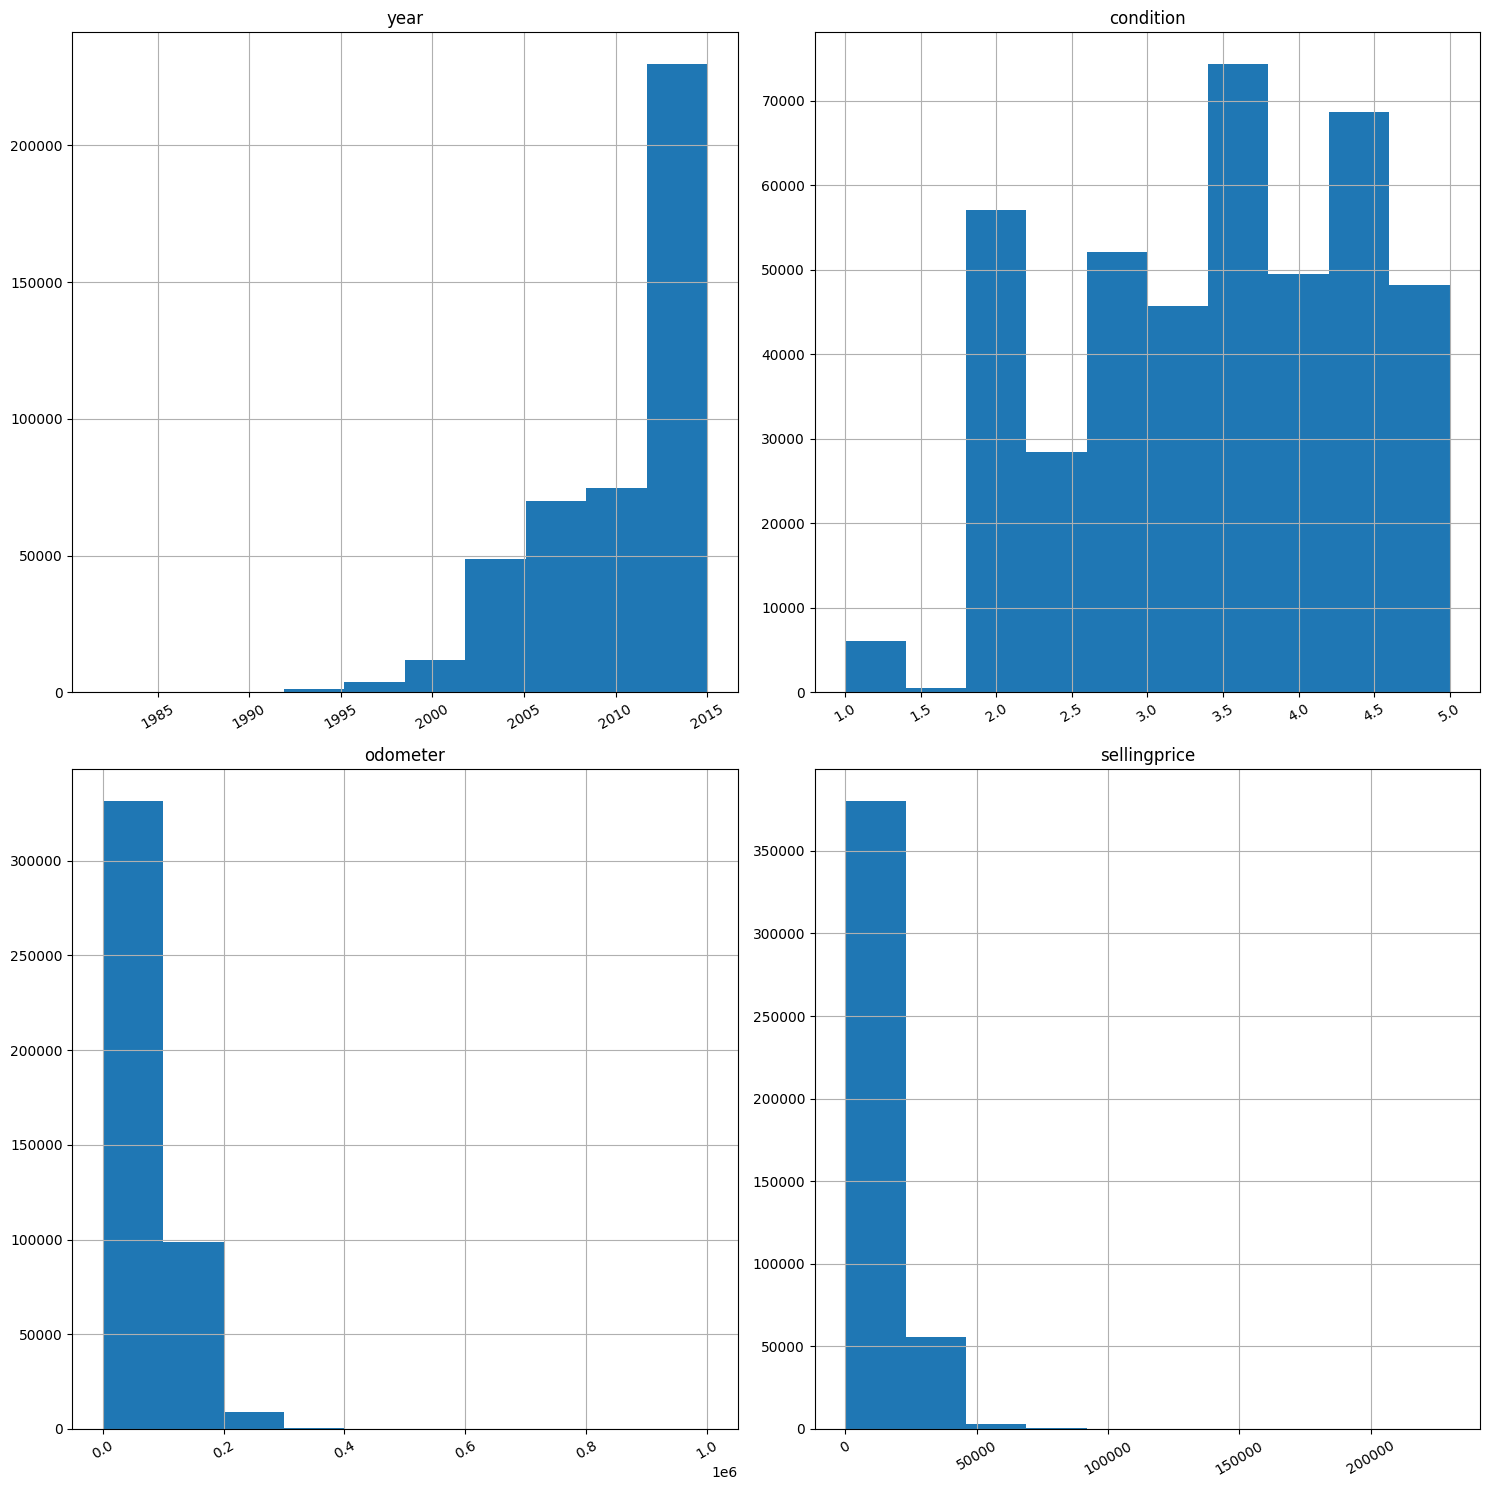

In [10]:
df.hist(figsize=(15,15), xrot=30)
plt.tight_layout()
plt.show()

In [11]:
def lowercase(row):
    return str(row).lower()

In [12]:
for column in df.select_dtypes('object').drop('saledate', axis=1).columns:
    df[column] = df[column].apply(lowercase)

In [13]:
for column in df.select_dtypes('object').drop('saledate', axis=1).columns:
    test[column] = test[column].apply(lowercase)

In [14]:
df.head()

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,saledate
0,2011,ford,edge,sel,suv,automatic,2fmdk3jc4bba41556,md,4.2,111041.0,black,black,santander consumer,12500,Tue Jun 02 2015 02:30:00 GMT-0700 (PDT)
1,2014,ford,fusion,se,sedan,automatic,3fa6p0h75er208976,mo,3.5,31034.0,black,black,ars/avis budget group,14500,Wed Feb 25 2015 02:00:00 GMT-0800 (PST)
2,2012,nissan,sentra,2.0 sl,sedan,automatic,3n1ab6ap4cl698412,nj,2.2,35619.0,black,black,nissan-infiniti lt,9100,Wed Jun 10 2015 02:30:00 GMT-0700 (PDT)
3,2003,hummer,h2,base,suv,automatic,5grgn23u93h101360,tx,2.8,131301.0,gold,beige,wichita falls ford lin inc,13300,Wed Jun 17 2015 03:00:00 GMT-0700 (PDT)
4,2007,ford,fusion,sel,sedan,automatic,3fahp08z17r268380,md,2.0,127709.0,black,black,purple heart,1300,Tue Feb 03 2015 04:00:00 GMT-0800 (PST)


In [15]:
df.select_dtypes(['int64', 'float64']).columns

Index(['year', 'condition', 'odometer', 'sellingprice'], dtype='object')

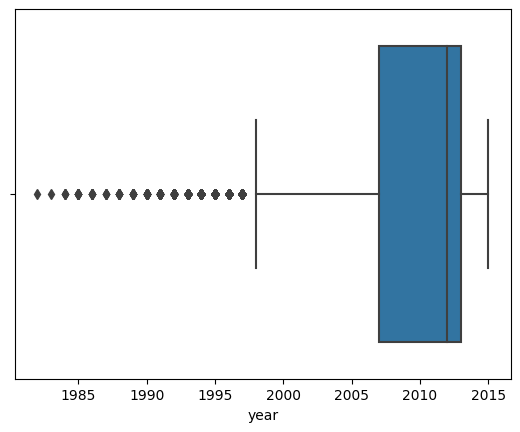

In [16]:
sns.boxplot(df.year);

In [17]:
len(df[df['year'] < 1997])

1989

In [18]:
df = df[df['year'] > 1997]

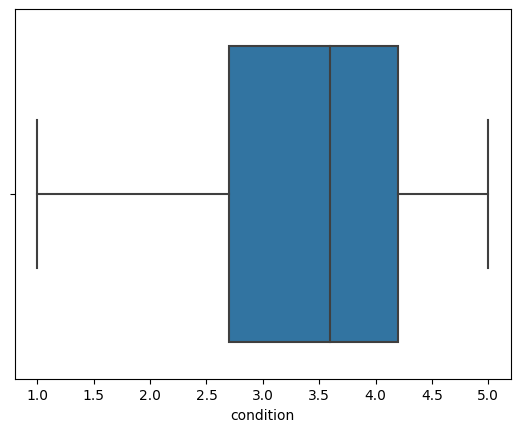

In [19]:
sns.boxplot(df['condition']);

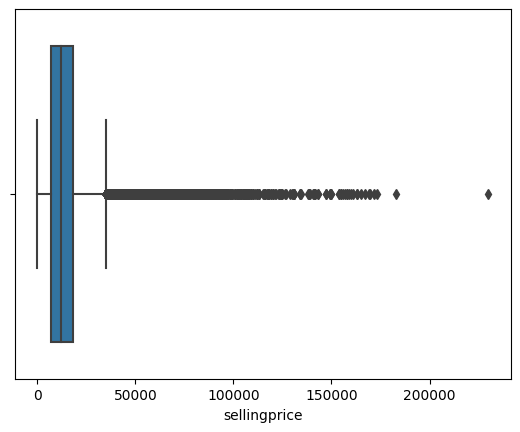

In [20]:
sns.boxplot(df['sellingprice']);

In [21]:
df[df['sellingprice'] > 200000]

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,saledate
392004,2014,ford,escape,titanium,suv,automatic,1fmcu9j98eua23833,mo,4.3,27802.0,green,tan,ford-lincoln dealer program,230000,Wed Feb 25 2015 02:00:00 GMT-0800 (PST)


Убираем данную строку из дата сета, как аномальную

In [22]:
df = df[df['sellingprice'] < 200000]

In [23]:
df[df['sellingprice'] > 150000]

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,saledate
13149,2014,bmw,i8,base,coupe,automatic,wby2z2c50evx64103,ca,5.0,603.0,white,beige,high bid trading co inc,158000,Thu Feb 12 2015 04:00:00 GMT-0800 (PST)
26083,2013,rolls-royce,ghost,base,sedan,automatic,sca664s52dux52152,fl,4.2,7852.0,white,beige,flag/landrover southpointe,171500,Wed Jun 17 2015 03:05:00 GMT-0700 (PDT)
33801,2012,ferrari,california,base,convertible,automatic,zff65tja5c0187066,ca,4.2,10902.0,gray,brown,chicago motor car corporation,154000,Tue Dec 30 2014 12:30:00 GMT-0800 (PST)
71372,2011,rolls-royce,ghost,base,sedan,automatic,sca664s55bux49503,ca,4.7,22761.0,black,beige,financial services remarketing (bmw int),155000,Thu May 21 2015 05:30:00 GMT-0700 (PDT)
117927,2012,ferrari,california,base,convertible,automatic,zff65lja1c0183418,fl,4.5,8149.0,silver,red,the collection,156000,Thu Dec 18 2014 09:15:00 GMT-0800 (PST)
134215,2014,bmw,i8,base,coupe,automatic,wby2z2c58evx64401,ca,4.4,303.0,white,gray,phelps auto sales,161000,Thu Feb 26 2015 04:30:00 GMT-0800 (PST)
174387,2013,bentley,continental gtc,base,convertible,automatic,scbgr3za1dc079560,ca,4.3,5593.0,black,brown,jaguar san diego,158000,Thu Feb 26 2015 04:00:00 GMT-0800 (PST)
189179,2014,bmw,i8,base,coupe,automatic,wby2z2c59evx64214,ca,5.0,60.0,white,brown,ferrari of orange county,165000,Thu Jan 15 2015 04:00:00 GMT-0800 (PST)
195471,2012,rolls-royce,ghost,ewb,sedan,automatic,sca664l50cux65625,ca,3.6,11832.0,white,black,bentley scottsdale,169000,Thu Jun 18 2015 05:30:00 GMT-0700 (PDT)
218054,2012,rolls-royce,ghost,base,sedan,automatic,sca664s59cux50803,ca,4.4,5215.0,white,tan,financial services remarketing (bmw int),167000,Thu Jun 18 2015 05:30:00 GMT-0700 (PDT)


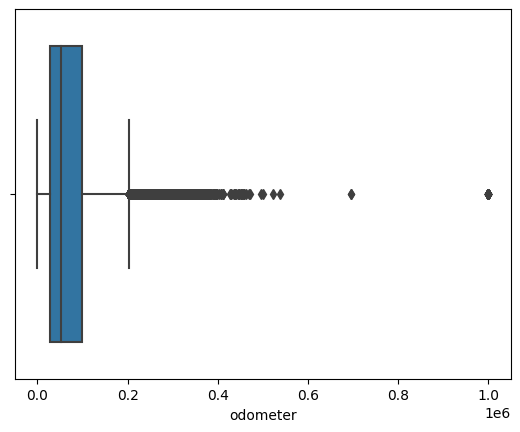

In [24]:
sns.boxplot(df['odometer']);

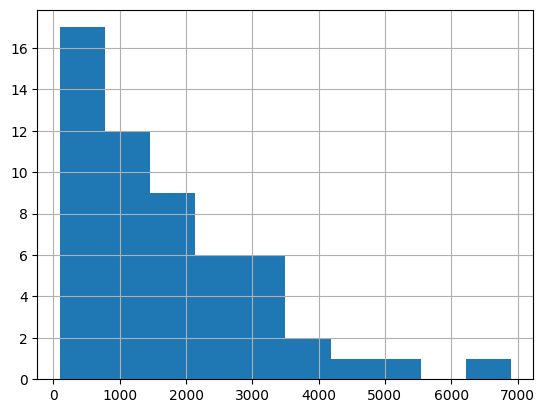

In [25]:
df[df['odometer'] > 600000]['sellingprice'].hist();

Воспользуемся функцией Vin модуля vininfo для извлечения информации о заводе и стране производства автомобиля.

In [26]:
def vin_make(row):
    vin_nom = Vin(row['vin'])   
    return vin_nom.manufacturer

In [27]:
df['maker'] = df.apply(vin_make, axis=1)
df.make = df.make.fillna(df.maker)
df.drop('maker', axis= 1 , inplace= True )

In [28]:
test['maker'] = test.apply(vin_make, axis=1)
test.make = test.make.fillna(test.maker)
test.drop('maker', axis= 1 , inplace= True )

In [29]:
def vin_country(row):
    vin = Vin(row['vin'])   
    return vin.country

In [30]:
df['country'] = df.apply(vin_country, axis=1)
test['country'] = test.apply(vin_country, axis=1)

In [31]:
df.country.unique()

array(['Canada', 'Mexico', 'United States', 'South Korea', 'Japan',
       'Sweden', 'Germany', 'United Kingdom', 'Brazil', 'Italy', 'Turkey',
       'Thailand', 'Finland', 'Hungary', 'Australia', 'France'],
      dtype=object)

In [32]:
test.country.unique()

array(['United States', 'Japan', 'Canada', 'Germany', 'Mexico',
       'South Korea', 'Sweden', 'Turkey', 'United Kingdom', 'Australia',
       'Italy', 'Thailand', 'Hungary', 'Brazil', 'France', 'Finland'],
      dtype=object)

In [33]:
df.country = df.country.replace(
    {'United States': 'USA', 'South Korea': 'Korea',
     'United Kingdom': 'England'}
)
df.country.unique()

array(['Canada', 'Mexico', 'USA', 'Korea', 'Japan', 'Sweden', 'Germany',
       'England', 'Brazil', 'Italy', 'Turkey', 'Thailand', 'Finland',
       'Hungary', 'Australia', 'France'], dtype=object)

In [34]:
test.country = test.country.replace(
    {'United States': 'USA', 'South Korea': 'Korea',
     'United Kingdom': 'England'}
)
test.country.unique()

array(['USA', 'Japan', 'Canada', 'Germany', 'Mexico', 'Korea', 'Sweden',
       'Turkey', 'England', 'Australia', 'Italy', 'Thailand', 'Hungary',
       'Brazil', 'France', 'Finland'], dtype=object)

Работаем со следующими столбцами

In [35]:
df.select_dtypes('object').columns

Index(['make', 'model', 'trim', 'body', 'transmission', 'vin', 'state',
       'color', 'interior', 'seller', 'saledate', 'country'],
      dtype='object')

In [36]:
make_d = list(df['make'].dropna().unique())
make_d.sort(key=lambda x: x[:2])
make_d

['acura',
 'airstream',
 'aston martin',
 'audi',
 'bentley',
 'bmw',
 'buick',
 'cadillac',
 'chevrolet',
 'chrysler',
 'daewoo',
 'dodge',
 'dot',
 'ferrari',
 'fiat',
 'fisker',
 'ford',
 'ford truck',
 'gmc',
 'gmc truck',
 'honda',
 'hummer',
 'hyundai',
 'infiniti',
 'isuzu',
 'jaguar',
 'jeep',
 'kia',
 'land rover',
 'landrover',
 'lamborghini',
 'lexus',
 'lincoln',
 'mazda',
 'maserati',
 'mazda tk',
 'mercedes-benz',
 'mercedes',
 'mercury',
 'mercedes-b',
 'mini',
 'mitsubishi',
 'nan',
 'nissan',
 'oldsmobile',
 'plymouth',
 'pontiac',
 'porsche',
 'ram',
 'rolls-royce',
 'saab',
 'saturn',
 'scion',
 'smart',
 'subaru',
 'suzuki',
 'tesla',
 'toyota',
 'volkswagen',
 'volvo',
 'vw']

In [37]:
make_t = list(test['make'].dropna().unique())
make_t.sort(key=lambda x: x[:2])
make_t

['acura',
 'aston martin',
 'audi',
 'bentley',
 'bmw',
 'buick',
 'cadillac',
 'chevrolet',
 'chrysler',
 'chev truck',
 'daewoo',
 'dodge',
 'ferrari',
 'fiat',
 'fisker',
 'ford',
 'ford tk',
 'geo',
 'gmc',
 'honda',
 'hummer',
 'hyundai',
 'hyundai tk',
 'infiniti',
 'isuzu',
 'jaguar',
 'jeep',
 'kia',
 'land rover',
 'landrover',
 'lexus',
 'lincoln',
 'lotus',
 'mazda',
 'maserati',
 'mercedes-benz',
 'mercury',
 'mercedes',
 'mitsubishi',
 'mini',
 'nan',
 'nissan',
 'oldsmobile',
 'plymouth',
 'pontiac',
 'porsche',
 'ram',
 'rolls-royce',
 'saturn',
 'saab',
 'scion',
 'smart',
 'subaru',
 'suzuki',
 'tesla',
 'toyota',
 'volkswagen',
 'volvo',
 'vw']

In [38]:
len(df[df['make'].isin(['dot', 'airstream'])])

2

In [39]:
df = df[~df['make'].isin(['dot', 'airstream'])]

In [40]:
rename_dict = {
    'gmc truck': 'gmc',
    'ford truck': 'ford',
    'land rover': "landrover",
    'mazda tk': 'mazda',
    'mercedes-benz': 'mercedes', 
    'mercedes-b': 'mercedes',
    'vw': 'volkswagen',
    'ford tk': 'ford',
    'hyundai tk': 'hyundai',
    'chev truck': 'chevrolet'
}

In [41]:
df['make'] = df['make'].rename(rename_dict)
test['make'] = test['make'].rename(rename_dict)


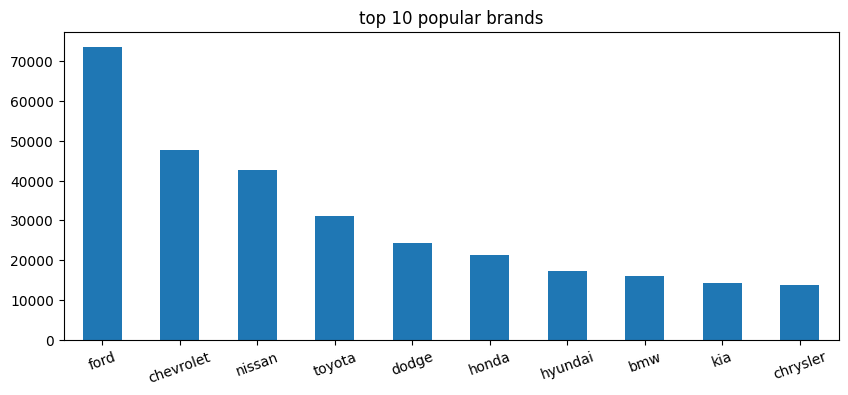

In [42]:
df['make'].value_counts(dropna=False).head(10).plot(kind='bar', rot=20, figsize=(10,4))
plt.title('top 10 popular brands')
plt.show()

In [43]:
model_d = list(filter(lambda x: x is not None, list(df.model.unique())))
model_d.sort(key=lambda x: x[:2])
model_d

['1 series',
 '1500',
 '2 series',
 '200',
 '200sx',
 '2500',
 '3',
 '3 series',
 '3 series gran turismo',
 '300',
 '300m',
 '3000gt',
 '320i',
 '328i',
 '323i',
 '3500',
 '350z',
 '370z',
 '4 series',
 '4 series gran coupe',
 '42c',
 '458 italia',
 '4runner',
 '5 series',
 '5 series gran turismo',
 '500l',
 '500',
 '500e',
 '6',
 '6 series',
 '6 series gran coupe',
 '626',
 '7',
 '7 series',
 '750i',
 '750li',
 '750lxi',
 '9-3',
 '9-7x',
 '9-5',
 '9-2x',
 '911',
 'a3',
 'a4',
 'a5',
 'a6',
 'a7',
 'a8',
 'accord',
 'accent',
 'acadia',
 'accord crosstour',
 'activehybrid x6',
 'activehybrid 7',
 'activehybrid 5',
 'accord hybrid',
 'aerio',
 'altima',
 'altima hybrid',
 'allroad quattro',
 'alero',
 'allroad',
 'alp',
 'amanti',
 'amigo',
 'armada',
 'aspen',
 'astro',
 'astra',
 'ascender',
 'astro cargo',
 'ats',
 'aura',
 'aurora',
 'aura hybrid',
 'avalon',
 'avenger',
 'avalanche',
 'aveo',
 'aviator',
 'avalon hybrid',
 'axiom',
 'azera',
 'aztek',
 'b-series truck',
 'b-series 

In [44]:
single_occurrences = sum(df.model.value_counts() == 1)

In [45]:
drops = df.model.value_counts().tail(single_occurrences).index.tolist()
df = df[~df.model.isin(drops)]

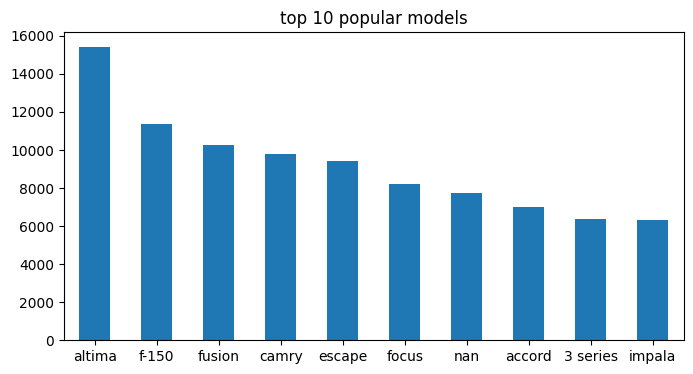

In [46]:
df.model.value_counts(dropna=False).head(10).plot(kind='bar', rot=0, figsize=(8,4))
plt.title('top 10 popular models')
plt.show()

In [47]:
len(df['trim'].value_counts(dropna=False))

1775

In [48]:
df['body'].value_counts(dropna=False).head(20)

sedan           189192
suv             112645
hatchback        20670
minivan          20114
coupe            13643
crew cab         12821
wagon            12529
nan               9858
convertible       8082
supercrew         7081
g sedan           5859
supercab          4143
regular cab       3781
van               3542
extended cab      3400
quad cab          3208
e-series van      1426
g coupe           1282
double cab        1260
crewmax cab        429
Name: body, dtype: int64

In [49]:
types = ['sedan', 'suv', 'hatchback', 'minivan', 'coupe', 'crew', 'cab', 'wagon', 'convertible', 'van']

In [50]:
def find_closest(row):
    if row is None:
        return
    row = str(row)
    
    best_match = None
    best_score = 1000
    for btype in types:
        if lev(btype, row) < best_score:
            best_match = btype
            best_score = lev(btype, row)
    return best_match

In [51]:
df['body'] = df['body'].apply(find_closest)

In [52]:
test['body'] = test['body'].apply(find_closest)

In [53]:
df['body'].value_counts()

sedan          204065
suv            112645
hatchback       20670
minivan         20548
crew            20331
coupe           16798
van             13400
wagon           12567
convertible      8446
cab              7508
Name: body, dtype: int64

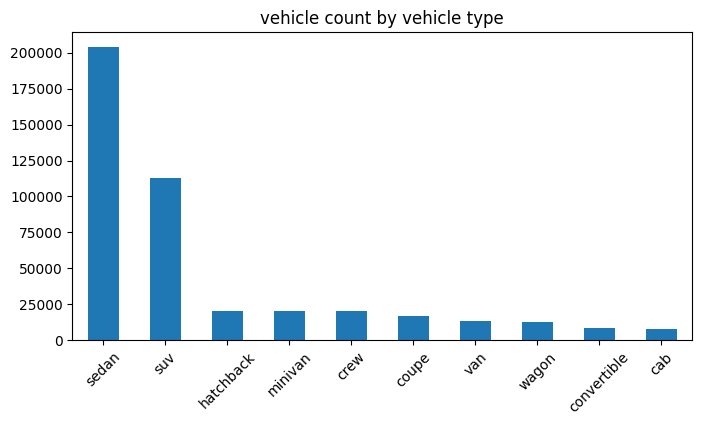

In [54]:
df['body'].value_counts(dropna=False).plot(kind='bar', rot=45, figsize=(8,4))
plt.title('vehicle count by vehicle type')
plt.show()

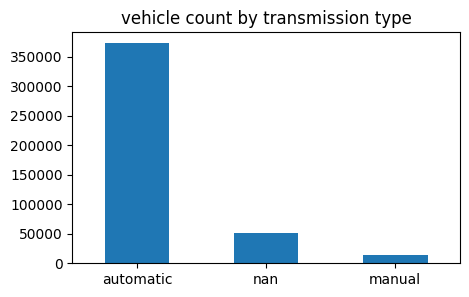

In [55]:
df['transmission'].value_counts(dropna=False).plot(kind='bar', rot=0, figsize=(5,3))
plt.title('vehicle count by transmission type')
plt.show()

In [56]:
df['state'].value_counts()

fl    65101
ca    56877
pa    42312
tx    35859
ga    26946
nj    22045
il    18602
oh    16850
nc    16813
tn    16095
mo    12532
mi    12377
nv     9692
va     9244
md     8620
wi     7832
mn     7424
az     6840
co     6106
wa     5752
ma     5267
ny     4520
in     3442
sc     3295
ne     3173
on     2716
pr     2132
la     1726
ms     1463
ut     1435
qc     1000
hi      990
or      917
ab      728
nm      124
ok       60
ns       52
al       19
Name: state, dtype: int64

In [57]:
df.color.unique()

array(['black', 'gold', 'silver', 'blue', 'white', 'gray', '—', 'red',
       'brown', 'green', 'beige', 'orange', 'nan', 'off-white',
       'burgundy', 'yellow', 'charcoal', 'purple', 'turquoise', 'lime',
       'pink'], dtype=object)

В данных дата сета заполняем '—' как 'undefined'

In [58]:
df[df.color == '—']['color'] = 'undefined'

In [59]:
df.interior.unique()

array(['black', 'beige', 'gray', 'tan', 'brown', '—', 'off-white', 'nan',
       'blue', 'white', 'silver', 'red', 'green', 'gold', 'purple',
       'orange', 'burgundy', 'yellow'], dtype=object)

In [60]:
df[df.interior == '—']['interior'] = 'undefined'

Смотрим пропуски

In [61]:
df.isna().sum()

year               0
make               0
model              0
trim               0
body               0
transmission       0
vin                0
state              0
condition       9131
odometer          67
color              0
interior           0
seller             0
sellingprice       0
saledate           0
country            0
dtype: int64

In [62]:
df[['body', 'transmission', 'color', 'interior']] = df[['body', 'transmission', 'color', 'interior']].fillna('undefined')

In [63]:
test[['body', 'transmission', 'color', 'interior']] = test[['body', 'transmission', 'color', 'interior']].fillna('undefined')

In [64]:
df.odometer.median()

51637.0

In [65]:
df.odometer = df.odometer.fillna(df.odometer.median())
test.odometer = test.odometer.fillna(test.odometer.median())

In [66]:
df.condition = df.condition.fillna(df.condition.median())
test.condition = test.condition.fillna(test.condition.median())

In [67]:
df[['make', 'model', 'trim']] = df[['make', 'model', 'trim']].fillna('undefined')
test[['make', 'model', 'trim']] = test[['make', 'model', 'trim']].fillna('undefined')

In [68]:
df.isna().sum()

year            0
make            0
model           0
trim            0
body            0
transmission    0
vin             0
state           0
condition       0
odometer        0
color           0
interior        0
seller          0
sellingprice    0
saledate        0
country         0
dtype: int64

In [69]:
test.isna().sum()

year            0
make            0
model           0
trim            0
body            0
transmission    0
vin             0
state           0
condition       0
odometer        0
color           0
interior        0
seller          0
saledate        0
country         0
dtype: int64

In [70]:
df['saledate'] = pd.to_datetime(df['saledate'])
df['saledate'] = df['saledate'].apply(lambda x: str(x)[:-6])
df['saledate'] = pd.to_datetime(df['saledate'])

In [71]:
test['saledate'] = pd.to_datetime(test['saledate'])
test['saledate'] = test['saledate'].apply(lambda x: str(x)[:-6])
test['saledate'] = pd.to_datetime(test['saledate'])

In [72]:
df = df.drop('interior', axis=1)

In [73]:
test = test.drop('interior', axis=1)

In [74]:
df['yearxcondition'] = df['year'] * df['condition']

In [75]:
test['yearxcondition'] = test['year'] * test['condition']

In [76]:
df['age'] = df['saledate'] - pd.to_datetime(df['year'], format='%Y')

In [77]:
test['age'] = test['saledate'] - pd.to_datetime(test['year'], format='%Y')

In [78]:
df['saledate'] = pd.to_numeric(df['saledate']) // 10e15
test['saledate'] = pd.to_numeric(test['saledate']) // 10e15

In [79]:
df['age'] = pd.to_numeric(df['age'])// 10e14
test['age'] = pd.to_numeric(df['age'])// 10e14

In [80]:
df.head()

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,seller,sellingprice,saledate,country,yearxcondition,age
0,2011,ford,edge,sel,suv,automatic,2fmdk3jc4bba41556,md,4.2,111041.0,black,santander consumer,12500,143.0,Canada,8446.2,139.0
1,2014,ford,fusion,se,sedan,automatic,3fa6p0h75er208976,mo,3.5,31034.0,black,ars/avis budget group,14500,142.0,Mexico,7049.0,36.0
2,2012,nissan,sentra,2.0 sl,sedan,automatic,3n1ab6ap4cl698412,nj,2.2,35619.0,black,nissan-infiniti lt,9100,143.0,Mexico,4426.4,108.0
3,2003,hummer,h2,base,suv,automatic,5grgn23u93h101360,tx,2.8,131301.0,gold,wichita falls ford lin inc,13300,143.0,USA,5608.4,393.0
4,2007,ford,fusion,sel,sedan,automatic,3fahp08z17r268380,md,2.0,127709.0,black,purple heart,1300,142.0,Mexico,4014.0,255.0


Сохраняем для повторного использования в будущем

In [81]:
cat_cols = df.select_dtypes('object').columns.tolist()
if not cat_cols:
    cat_cols = df.select_dtypes('category').columns.tolist()
cat_cols

['make',
 'model',
 'trim',
 'body',
 'transmission',
 'vin',
 'state',
 'color',
 'seller',
 'country']

In [82]:
df[cat_cols] = df[cat_cols].astype('category')

### Вывод:

Удалили неявные дубликаты.

Заполнили пропуски во всех имеющихся данных:

- с помощью vin востановили непонятные значения и создали признак country - страна производитель автомобиля.

- тип коробки передач заполнили по характеристикам конкретных моделей;

- пропуски в данных о пробеге и состоянии автомобиля – медианным значением в зависимости от периода владения автомобилем.

На данном этапе мы удалили часть выбросов, чтобы снизить зашумленность данных и повысить точность модели.

Подготовили итоговые данные для дальнейшей работы.

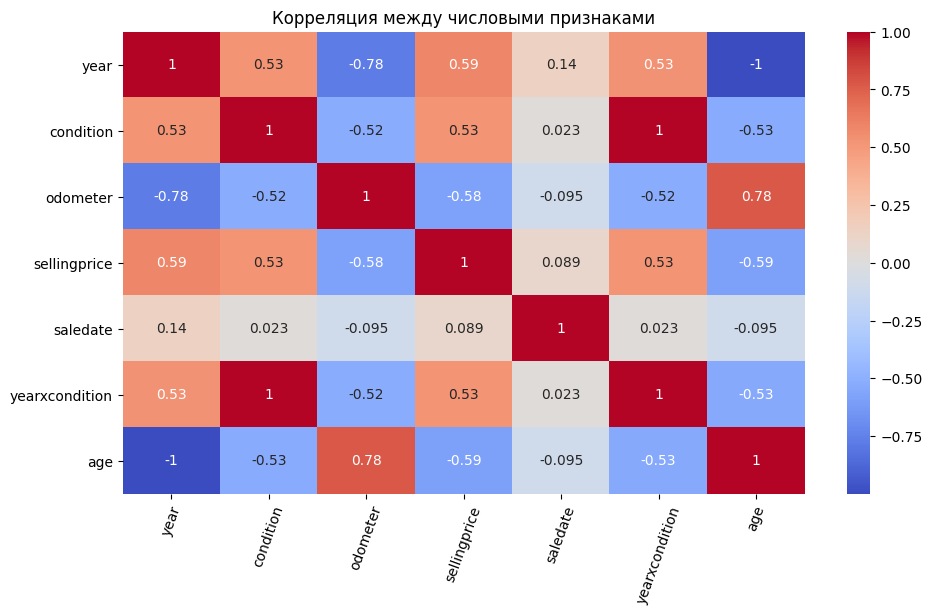

In [83]:
chart = sns.heatmap(
    df.corr(),
    cmap='coolwarm',
    annot=True
)
chart.set_title('Корреляция между числовыми признаками')
chart.set_xticklabels(chart.get_xticklabels(), rotation=70)
fig = chart.get_figure()
fig.set_size_inches(11, 6)
chart;

In [84]:
X_train = df.drop(['sellingprice'], axis=1)
y_train = df['sellingprice']

In [85]:
X_test = test.copy()

In [86]:
OE = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

In [87]:
X_train_oe = X_train.copy()
X_test = test.copy()

X_train_oe[cat_cols] = OE.fit_transform(X_train[cat_cols])
X_test[cat_cols] = OE.transform(X_test[cat_cols])

In [88]:
print(f'{X_train_oe.shape = }')
(f'{X_test.shape = }')

X_train_oe.shape = (436978, 16)


'X_test.shape = (110058, 16)'

In [89]:
metrics = {
    'fit time, seconds': {},
    'best score (MAPE)': {},
}


def metrics_append(model_name, val1, val2):
    metrics['fit time, seconds'][model_name] = val1
    metrics['best score (MAPE)'][model_name] = val2

In [90]:
from functools import wraps


def timeit(func) -> tuple or int:
    @wraps(func)
    def inner(*args, **kwargs):
        start = datetime.now()
        result = func(*args, **kwargs)
        end = datetime.now()

        print(f'Execution time: {(end - start).seconds:.2f} seconds') 
        if result is not None:
            return (end - start).seconds, result
        else:
            return (end - start).seconds
    return inner

In [91]:
@timeit
def model_fit(model, X_train, y_train=None, **kwargs) -> None:
    model.fit(X_train, y_train, **kwargs)

получение категориальных столбцов

In [92]:
col_indices = [X_train_oe.columns.get_loc(col) for col in cat_cols]

**1. Случайный лес**

In [104]:
param1 = {
    'criterion' : ['poisson'],
    'max_depth' : [5],
    'n_estimators' : [200]
}

In [107]:
mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)

In [108]:
GSrfr = GridSearchCV(
    estimator=RandomForestRegressor(random_state=12345),
    param_grid=param1,
    scoring=mape_scorer,
    refit='mape_scorer',
    cv=3,
    verbose=4
)

In [110]:
GSrfr_CV_time = model_fit(GSrfr, X_train_oe, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END criterion=poisson, max_depth=5, n_estimators=200;, score=-0.571 total time=21.1min
[CV 2/3] END criterion=poisson, max_depth=5, n_estimators=200;, score=-0.477 total time=20.6min
[CV 3/3] END criterion=poisson, max_depth=5, n_estimators=200;, score=-0.515 total time=23.3min
Execution time: 5968.00 seconds


In [111]:
GSrfr.best_estimator_

RandomForestRegressor(criterion='poisson', max_depth=5, n_estimators=200,
                      random_state=12345)

In [114]:
f'MAPE score: {mean_absolute_percentage_error(y_train, GSrfr.predict(X_train_oe)):.3%}'

'MAPE score: 52.342%'

**2. Деревья решений**

In [115]:
param2= {"max_depth": list(range(18, 19))}

In [116]:
DTR = GridSearchCV(
    estimator=DecisionTreeRegressor(random_state=12345),
    param_grid=param2,
    scoring=mape_scorer,
    refit='mape_scorer',
    cv=3,
    verbose=4
)

In [117]:
DTR_CV_time = model_fit(DTR, X_train_oe, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END .....................max_depth=18;, score=-0.242 total time=  34.3s
[CV 2/3] END .....................max_depth=18;, score=-0.213 total time=  36.8s
[CV 3/3] END .....................max_depth=18;, score=-0.264 total time=  33.2s
Execution time: 152.00 seconds


In [118]:
DTR.best_estimator_

DecisionTreeRegressor(max_depth=18, random_state=12345)

In [119]:
f'MAPE CV score: {mean_absolute_percentage_error(y_train, DTR.predict(X_train_oe)):.3%}'

'MAPE CV score: 11.816%'

**3.Градиентный бустинг - LGBMRegressor**

In [93]:
gbm = lgb.LGBMRegressor(
    application='regression',
    metric='mae',
    categorical_feature=col_indices 
)

In [94]:
params = {
    'learning_rate': [0.1],
    'max_bin': [255],
    'n_estimators': [300], 
    'num_leaves': [400],
    'max_depth': [20]
}

In [95]:
grid_gbm = GridSearchCV(gbm, params, cv=3, n_jobs=-1, scoring='neg_mean_absolute_error')

In [96]:
gbm_CV_time = model_fit(grid_gbm, X_train_oe, y_train)

C:\Users\Family\anaconda3\envs\ds_practicum_env\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'


Execution time: 612.00 seconds


In [97]:
grid_gbm.best_estimator_

LGBMRegressor(application='regression',
              categorical_feature=[1, 2, 3, 4, 5, 6, 7, 10, 11, 13],
              max_bin=255, max_depth=20, metric='mae', n_estimators=300,
              num_leaves=400)

In [98]:
(-grid_gbm.best_score_)

1027.011147444075

Проведем анализ важности признаков лучшей модели

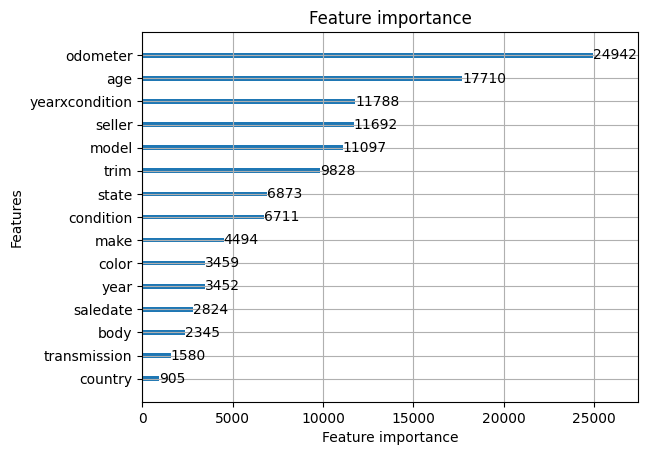

In [99]:
lgb.plot_importance(grid_gbm.best_estimator_)
plt.show()

Из полученых данных видно, что важными признаками для предсказания стоимости автомобиля являются:

пробег автомобиля,

возраст,

года производства.

In [100]:
metrics_append('LightGBM', gbm_CV_time, (-grid_gbm.best_score_))

In [101]:
pd.set_option('display.float_format', lambda x: '%.0f' % x)
pd.DataFrame(metrics).T

,LightGBM
"fit time, seconds",612
best score (MAPE),1027


In [102]:
f'MAPE CV score: {mean_absolute_percentage_error(y_train, grid_gbm.predict(X_train_oe)):.3%}'

'MAPE CV score: 11.557%'

 **Вывод:**

Перед нами стояла задача регрессии: необходимо на основе имеющихся данных предсказать цену автомобиля на вторичном рынке.

Имеется датасет, содержащий 440236, 15 характеристик и целевой признак.

Датасет, доступный для обучения, очень сильно по своим характеристикам похож на тестовый.

Удалили неявные дубликаты.

Заполнили пропуски во всех имеющихся данных:

с помощью vin востановили непонятные значения и создали признак country - страна производитель автомобиля.

пропуски в данных о пробеге и состоянии автомобиля – медианным значением в зависимости от периода владения автомобилем.

После обработки пропусков и дубликатов был проведен разведывательный анализ данных.

**Общий вывод:**

В ходе выполнения проекта была создана модель предсказания стоимости автомобиля по его характеристикам.

Лучшей результат метрики MAPE = 11.56 показал LGBMRegressor.